<a href="https://colab.research.google.com/github/tejasspawar/face-mask-detection/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [33]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 28.6 MB/s 
     |████████████████████████████████| 1.6 MB 63.2 MB/s 


In [2]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Creating X and y

## Sample of original image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Face mask data/mask/1.png'
img = cv2.imread(path)
img.shape

(96, 96, 3)

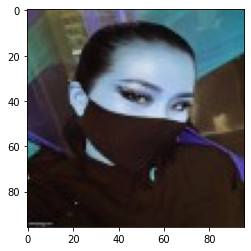

In [5]:
plt.imshow(img)

## Appending With mask images

In [6]:
 X = []
 X_scaled = []
 y = []
 for i in range(1,595):
   try:
     path = '/content/drive/MyDrive/Face mask data/mask/{}.png'.format(i)
     img = cv2.imread(path)    
     X.append(img)
     X_scaled.append(img/255)
     y.append(1)
   except:
     pass


## Appending without mask images

In [7]:
for i in range(1,617):
   try:
     path = '/content/drive/MyDrive/Face mask data/without_mask/{}.png'.format(i)
     img = cv2.imread(path)    
     X.append(img)
     X_scaled.append(img/255)
     y.append(0)
   except:
     pass  

# Train-Test split

In [8]:
X = np.array(X)
X_scaled = np.array(X_scaled)
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=0, stratify=y)

# Training CNN

In [10]:
cnn1 = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [11]:
cnn1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
cnn1.fit(X_train, y_train, epochs=5)

Epoch 1/5
33/33 [==============================] - 12s 13ms/step - loss: 0.6790 - accuracy: 0.6849
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 0.3395 - accuracy: 0.8790
Epoch 3/5
33/33 [==============================] - 0s 8ms/step - loss: 0.2627 - accuracy: 0.8995
Epoch 4/5
33/33 [==============================] - 0s 8ms/step - loss: 0.2594 - accuracy: 0.8976
Epoch 5/5
33/33 [==============================] - 0s 8ms/step - loss: 0.1963 - accuracy: 0.9229


# Classification report of test data


In [13]:
from sklearn.metrics import confusion_matrix , classification_report
y_pred = cnn1.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.71      0.81        93
           1       0.76      0.96      0.85        89

    accuracy                           0.83       182
   macro avg       0.85      0.83      0.83       182
weighted avg       0.85      0.83      0.83       182



# Testing


In [14]:
test_path_wm = '/content/drive/MyDrive/Face mask data/test/wmask_test1.png'
test_path_m = '/content/drive/MyDrive/Face mask data/test/mask_test1.png'
img_wm = cv2.imread(test_path_wm)
img_wm = cv2.resize(img_wm,(96,96))
img_wm= img_wm/255
img_m = cv2.imread(test_path_m)
img_m = cv2.resize(img_m,(96,96))
img_m= img_m/255

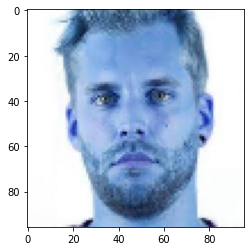

In [15]:
plt.imshow(img_wm)

In [16]:
# Not Wearing mask
if cnn1.predict(np.array([img_wm]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is not wearing a mask


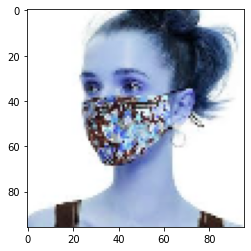

In [17]:
plt.imshow(img_m)

In [18]:
# Wearing mask
if cnn1.predict(np.array([img_m]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is wearing a mask


# Training CNN with Data Augmentaion


In [19]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(96, 
                                                              96,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

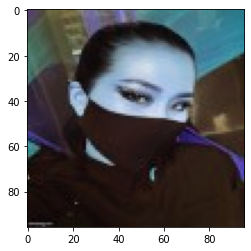

In [20]:
# Previous
plt.imshow(X_scaled[0])

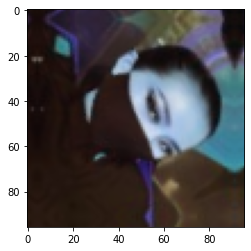

In [21]:
# After augmentation
plt.imshow(data_augmentation(X_scaled)[0])

In [22]:
cnn2 = models.Sequential([
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [23]:
cnn2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
cnn2.fit(X_train, y_train, epochs=5)

Epoch 1/5
33/33 [==============================] - 1s 12ms/step - loss: 0.6798 - accuracy: 0.7083
Epoch 2/5
33/33 [==============================] - 0s 10ms/step - loss: 0.3843 - accuracy: 0.8478
Epoch 3/5
33/33 [==============================] - 0s 10ms/step - loss: 0.3310 - accuracy: 0.8693
Epoch 4/5
33/33 [==============================] - 0s 10ms/step - loss: 0.3324 - accuracy: 0.8595
Epoch 5/5
33/33 [==============================] - 0s 10ms/step - loss: 0.3320 - accuracy: 0.8527


# Classification report of test data


In [25]:
from sklearn.metrics import confusion_matrix , classification_report
y_pred = cnn2.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93        93
           1       0.93      0.91      0.92        89

    accuracy                           0.92       182
   macro avg       0.92      0.92      0.92       182
weighted avg       0.92      0.92      0.92       182



# Testing

In [26]:
test_path_wm = '/content/drive/MyDrive/Face mask data/test/wmask_test1.png'
test_path_m = '/content/drive/MyDrive/Face mask data/test/mask_test1.png'
img_wm = cv2.imread(test_path_wm)
img_wm = cv2.resize(img_wm,(96,96))
img_wm= img_wm/255
img_m = cv2.imread(test_path_m)
img_m = cv2.resize(img_m,(96,96))
img_m= img_m/255

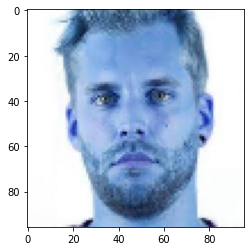

In [27]:
plt.imshow(img_wm)

In [28]:
# Not Wearing mask
if cnn2.predict(np.array([img_wm]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is not wearing a mask


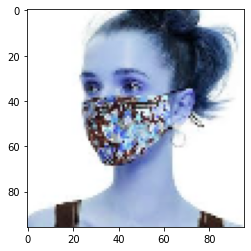

In [29]:
plt.imshow(img_m)

In [30]:
# Wearing mask
if cnn2.predict(np.array([img_m]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is wearing a mask


# Training CNN using keras tuner

In [31]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(96,96,3)
    ),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(2, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [34]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [35]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="Mnist Fashion")

In [36]:
tuner_search.search(X_train,y_train,epochs=3,validation_split=0.1)

Trial 5 Complete [00h 00m 06s]
val_accuracy: 0.4757281541824341

Best val_accuracy So Far: 0.6893203854560852
Total elapsed time: 00h 00m 20s


In [37]:
model=tuner_search.get_best_models(num_models=1)[0]

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 14112)             0         
                                                                 
 dense (Dense)               (None, 112)               1

In [39]:
model.fit(X_train, y_train, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
29/29 [==============================] - 1s 19ms/step - loss: 0.5659 - accuracy: 0.7158 - val_loss: 0.6640 - val_accuracy: 0.6117
Epoch 5/10
29/29 [==============================] - 0s 11ms/step - loss: 0.6653 - accuracy: 0.5998 - val_loss: 0.6844 - val_accuracy: 0.5534
Epoch 6/10
29/29 [==============================] - 0s 11ms/step - loss: 0.5577 - accuracy: 0.6974 - val_loss: 0.5957 - val_accuracy: 0.6505
Epoch 7/10
29/29 [==============================] - 0s 11ms/step - loss: 0.4353 - accuracy: 0.7993 - val_loss: 0.6113 - val_accuracy: 0.7476
Epoch 8/10
29/29 [==============================] - 0s 10ms/step - loss: 0.3853 - accuracy: 0.8362 - val_loss: 0.4844 - val_accuracy: 0.7961
Epoch 9/10
29/29 [==============================] - 0s 10ms/step - loss: 0.2984 - accuracy: 0.8698 - val_loss: 0.4307 - val_accuracy: 0.8058
Epoch 10/10
29/29 [==============================] - 0s 10ms/step - loss: 0.2593 - accuracy: 0.9002 - val_loss: 0.3676 - val_accuracy: 0.8544


# Classification report of test data


In [40]:
from sklearn.metrics import confusion_matrix , classification_report
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.86      0.89        93
           1       0.86      0.93      0.90        89

    accuracy                           0.90       182
   macro avg       0.90      0.90      0.90       182
weighted avg       0.90      0.90      0.90       182



# Testing

In [41]:
test_path_wm = '/content/drive/MyDrive/Face mask data/test/wmask_test1.png'
test_path_m = '/content/drive/MyDrive/Face mask data/test/mask_test1.png'
img_wm = cv2.imread(test_path_wm)
img_wm = cv2.resize(img_wm,(96,96))
img_wm= img_wm/255
img_m = cv2.imread(test_path_m)
img_m = cv2.resize(img_m,(96,96))
img_m= img_m/255

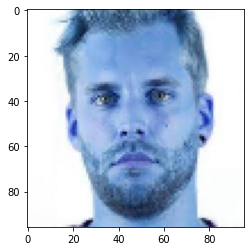

In [42]:
plt.imshow(img_wm)

In [43]:
# Not Wearing mask
if model.predict(np.array([img_wm]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is not wearing a mask


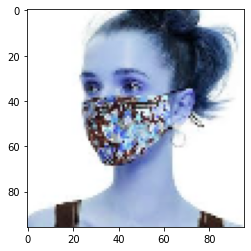

In [44]:
plt.imshow(img_m)

In [45]:
# Wearing mask
if model.predict(np.array([img_m]))[0][1]>0.5:
  print('Person is wearing a mask')
else:
  print('Person is not wearing a mask')


Person is wearing a mask
